# ML Experiment Analysis — Cybersecurity Attacks

**Created:** 2025-12-29 20:25 (local)

This notebook analyzes the latest ML experiment results for **anomaly_scores** (regression) and **attack_type** (multiclass classification).

## What this notebook does

- Loads the latest prepared dataset under `data/02-preprocessed/` and the shared time-aware split (`split_time_70_15_15.csv`).
- Uses the canonical baseline feature config (`config/baseline_feature_config.json`) to keep comparisons consistent.
- **Anomaly Scores**: trains a set of regression models and evaluates on val/test with regression metrics.
- **Attack Type**: loads the latest saved training artifacts under `data/04-predictions/attack_type/training/` (metrics + test predictions) and computes plots/tables.
- Saves every plot as a PNG in `notebooks/analysis_2025-12-29_20-25/`.

In [7]:
# Imports, reproducibility, and repo-relative paths
from __future__ import annotations

import json
import os
import random
import sys
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib.colors import LinearSegmentedColormap

from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR

try:
    from xgboost import XGBRegressor
except Exception as exc:
    raise RuntimeError('xgboost is required (see requirements.txt).') from exc

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# NumPy FutureWarning guard mentioned in repo prompt
if not hasattr(np, 'object'):
    np.object = object

# --- Resolve repo root robustly ---
cwd = Path.cwd().resolve()
candidates = [cwd] + list(cwd.parents)
REPO_ROOT = next((p for p in candidates if (p / 'src').exists() and (p / 'data').exists()), None)
if REPO_ROOT is None:
    raise FileNotFoundError('Could not locate repo root (expected src/ and data/).')

# Ensure repo-root imports work in notebooks (so `import src...` succeeds)
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

OUTPUT_DIR = REPO_ROOT / 'notebooks' / 'analysis_2025-12-29_20-25'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

DATASET_ROOT = REPO_ROOT / 'data' / '02-preprocessed'
PRED_ROOT = REPO_ROOT / 'data' / '04-predictions'
BASELINE_CONFIG_JSON = REPO_ROOT / 'config' / 'baseline_feature_config.json'
VIZ_CONFIG_JSON = REPO_ROOT / 'config' / 'visualization.json'

print('Repo root :', REPO_ROOT)
print('Output dir:', OUTPUT_DIR)

def load_color_palette(path: Path) -> list[str]:
    payload = json.loads(path.read_text(encoding='utf-8'))
    # Support both legacy and repo-specific schema shapes
    colors = payload.get('palette')
    if not colors:
        colors = payload.get('visualization', {}).get('color_palette')
    if not colors:
        raise ValueError(f'No colors found in {path}')
    return list(colors)

COLOR_PALLETTE = load_color_palette(VIZ_CONFIG_JSON)
plt.rcParams['axes.prop_cycle'] = cycler(color=COLOR_PALLETTE)
CMAP = LinearSegmentedColormap.from_list('repo_palette', COLOR_PALLETTE)

print('Loaded palette colors:', len(COLOR_PALLETTE))

# Notebook folder reconnaissance (results already exist under notebooks/*)
anom_nb = sorted((REPO_ROOT / 'notebooks' / 'anomaly_scores').glob('experiment_*.ipynb'))
atk_nb = sorted((REPO_ROOT / 'notebooks' / 'attack_type').glob('experiment_*.ipynb'))
print('Found anomaly experiment notebooks:', len(anom_nb))
print('Found attack_type experiment notebooks:', len(atk_nb))

Repo root : C:\repos\ml-cybersecurity_attacks
Output dir: C:\repos\ml-cybersecurity_attacks\notebooks\analysis_2025-12-29_20-25
Loaded palette colors: 9
Found anomaly experiment notebooks: 9
Found attack_type experiment notebooks: 19


## A.1 — Dataset & Evaluation Strategy

This repository uses a **time-aware split** (`split_time_70_15_15.csv`) to reduce temporal leakage: train/val/test are assigned chronologically.

- **Train**: fit preprocessing + model parameters
- **Validation**: model selection / tuning (kept separate from test)
- **Test**: final evaluation only

**Metrics:**
- **Attack Type (multiclass):** accuracy + macro/weighted F1 (macro highlights per-class balance).
- **Anomaly Scores (regression):** MAE/RMSE/R² (RMSE penalizes larger errors).

In [4]:
# Load the latest prepared dataset + shared time split
prepared_dirs = sorted([p for p in DATASET_ROOT.iterdir() if p.is_dir()], key=lambda p: p.name)
if not prepared_dirs:
    raise FileNotFoundError('No prepared datasets found under data/02-preprocessed/')
DATASET_DIR = prepared_dirs[-1]

cleaned_parquet = DATASET_DIR / 'cleaned.parquet'
cleaned_csv = DATASET_DIR / 'cleaned.csv'
split_time_csv = DATASET_DIR / 'split_time_70_15_15.csv'
classes_json = DATASET_DIR / 'attack_type_classes.json'

print('Using prepared dataset:', DATASET_DIR.name)

if cleaned_parquet.exists():
    df = pd.read_parquet(cleaned_parquet)
elif cleaned_csv.exists():
    df = pd.read_csv(cleaned_csv)
else:
    raise FileNotFoundError('Expected cleaned.parquet or cleaned.csv in prepared dataset dir')

splits = pd.read_csv(split_time_csv)
classes_payload = json.loads(classes_json.read_text(encoding='utf-8'))
ATTACK_CLASSES = list(classes_payload.get('classes', []))

df_split = df[['row_id']].merge(splits[['row_id', 'split', 'Timestamp']], on='row_id', how='left')
if df_split['split'].isna().any():
    raise ValueError('Some rows are missing split assignments (split_time join failed)')

mask_train = df_split['split'].eq('train')
mask_val = df_split['split'].eq('val')
mask_test = df_split['split'].eq('test')

print('Rows:', len(df), 'train:', int(mask_train.sum()), 'val:', int(mask_val.sum()), 'test:', int(mask_test.sum()))

ts = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True)
print('Attack classes:', ATTACK_CLASSES)

Using prepared dataset: cybersecurity_attacks_v1_2025-12-29
Rows: 40000 train: 28000 val: 6000 test: 6000
Attack classes: ['DDoS', 'Intrusion', 'Malware']


## A.2 — Training & Validation Analysis (Anomaly Scores)

Each experiment below trains a regression model to predict **`Anomaly Scores`** using the shared baseline feature engineering.

For each model we generate:
- A learning curve (train vs validation RMSE across increasing train sizes)
- Val/test metrics (MAE/RMSE/R²)
- Test diagnostics (pred vs true, residuals, and true vs pred over time)

In [8]:
from src.pipelines.features import (
    BaselineFeatureConfig,
    apply_baseline_feature_config,
    load_baseline_feature_config,
)

def make_preprocess(X: pd.DataFrame, *, needs_scaling: bool) -> ColumnTransformer:
    cat_cols = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith('string')]
    num_cols = [c for c in X.columns if c not in cat_cols]

    cat_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ])

    num_steps = [('imputer', SimpleImputer(strategy='median'))]
    if needs_scaling:
        num_steps.append(('scaler', StandardScaler()))
    num_pipe = Pipeline(steps=num_steps)

    return ColumnTransformer(
        transformers=[('cat', cat_pipe, cat_cols), ('num', num_pipe, num_cols)],
        remainder='drop',
    )

def regression_metrics(y_true, y_pred) -> dict:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = r2_score(y_true, y_pred)
    return {'mae': float(mae), 'rmse': float(rmse), 'r2': float(r2)}

def pretty_print_regression(label: str, m: dict) -> None:
    print('==', label, '==')
    print('MAE :', f"{m['mae']:.4f}")
    print('RMSE:', f"{m['rmse']:.4f}")
    print('R2  :', f"{m['r2']:.4f}")

def plot_learning_curve_rmse(model: Pipeline, title: str, png_name: str) -> None:
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_train,
        y_train,
        train_sizes=np.linspace(0.2, 1.0, 5),
        cv=3,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        shuffle=True,
        random_state=SEED,
    )

    train_rmse = -train_scores.mean(axis=1)
    val_rmse = -val_scores.mean(axis=1)

    plt.figure(figsize=(7, 4))
    plt.plot(train_sizes, train_rmse, marker='o', label='Train RMSE')
    plt.plot(train_sizes, val_rmse, marker='o', linestyle='--', label='Val RMSE')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('RMSE (lower is better)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    savefig(png_name)
    plt.show()

def plot_regression_diagnostics(name: str, y_true, y_pred, ts_index, prefix: str) -> None:
    # Pred vs true
    plt.figure(figsize=(6, 5))
    plt.scatter(y_true, y_pred, s=8, alpha=0.35)
    lo = float(np.nanmin([np.min(y_true), np.min(y_pred)]))
    hi = float(np.nanmax([np.max(y_true), np.max(y_pred)]))
    plt.plot([lo, hi], [lo, hi], linestyle='--', linewidth=1, label='Ideal')
    plt.title(name + ' — Test: Predicted vs True')
    plt.xlabel('True Anomaly Scores')
    plt.ylabel('Predicted Anomaly Scores')
    plt.grid(True, alpha=0.3)
    plt.legend()
    savefig(prefix + '_pred_vs_true.png')
    plt.show()

    # Residuals
    resid = (np.asarray(y_true) - np.asarray(y_pred))
    plt.figure(figsize=(7, 4))
    plt.hist(resid, bins=60, alpha=0.9)
    plt.title(name + ' — Test residual distribution (true - pred)')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    savefig(prefix + '_residuals.png')
    plt.show()

    # Time series overlay (sorted by timestamp)
    order = np.argsort(ts_index.values.astype('datetime64[ns]'))
    ts_sorted = ts_index.iloc[order]
    y_true_sorted = np.asarray(y_true)[order]
    y_pred_sorted = np.asarray(y_pred)[order]

    plt.figure(figsize=(10, 4))
    plt.plot(ts_sorted, y_true_sorted, label='True', linewidth=1)
    plt.plot(ts_sorted, y_pred_sorted, label='Pred', linewidth=1, linestyle='--')
    plt.title(name + ' — Test: True vs Pred over time')
    plt.xlabel('Timestamp')
    plt.ylabel('Anomaly Scores')
    plt.grid(True, alpha=0.3)
    plt.legend()
    savefig(prefix + '_over_time.png')
    plt.show()

Anomaly regression split sizes: (28000, 24) (6000, 24) (6000, 24)

Anomaly regression experiment: Linear Regression
== Val ==
MAE : 25.0273
RMSE: 28.9299
R2  : -0.0002
== Test ==
MAE : 25.0375
RMSE: 28.9135
R2  : -0.0005


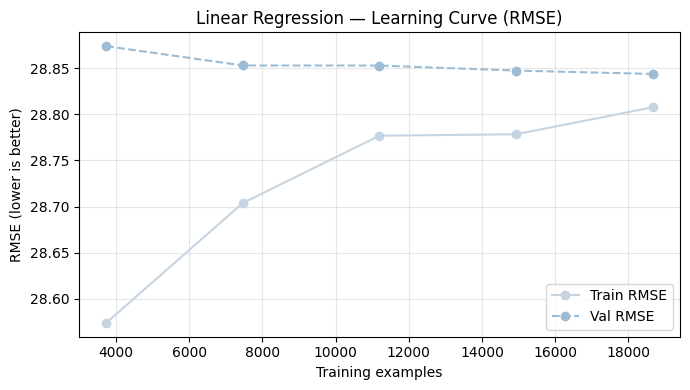

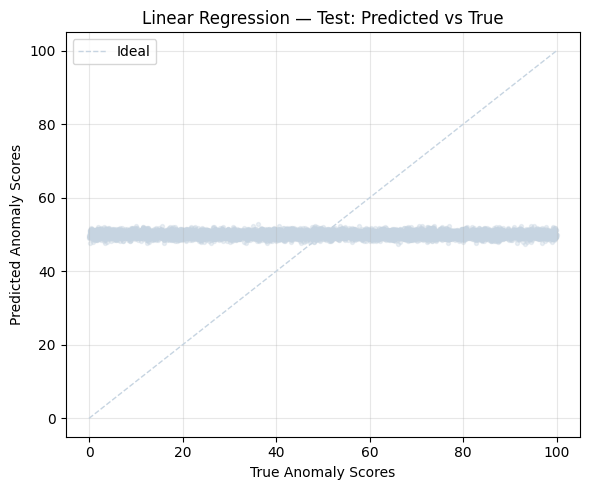

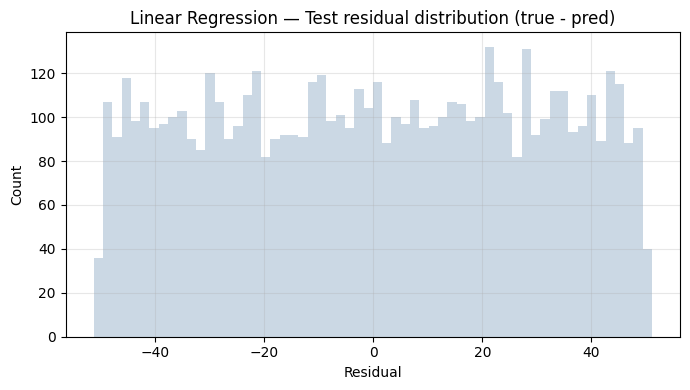

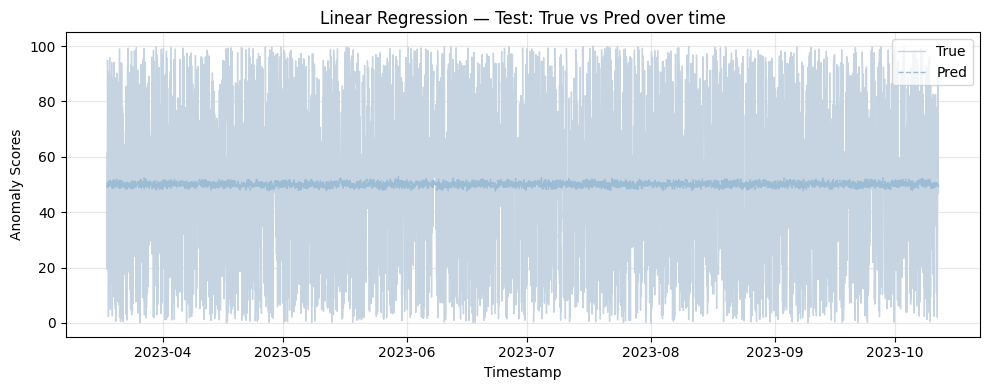


Anomaly regression experiment: Ridge Regression
== Val ==
MAE : 25.0273
RMSE: 28.9299
R2  : -0.0002
== Test ==
MAE : 25.0375
RMSE: 28.9135
R2  : -0.0005


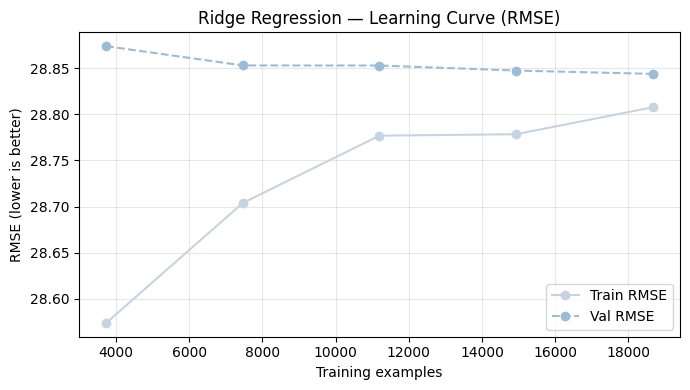

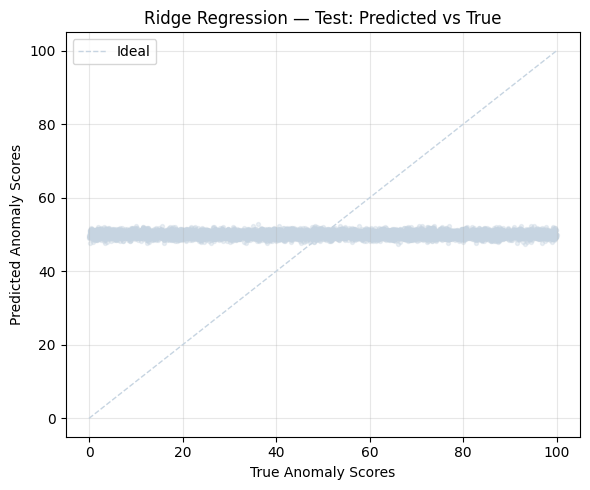

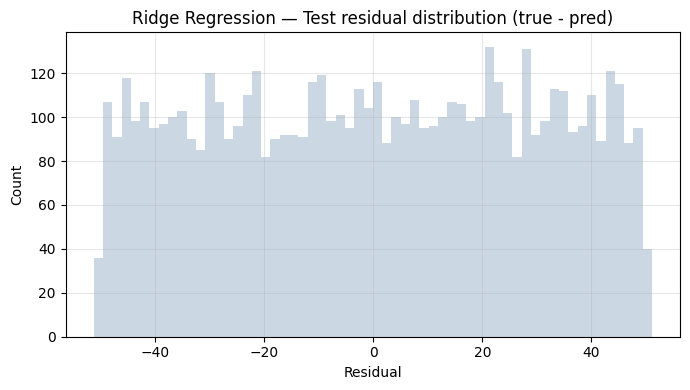

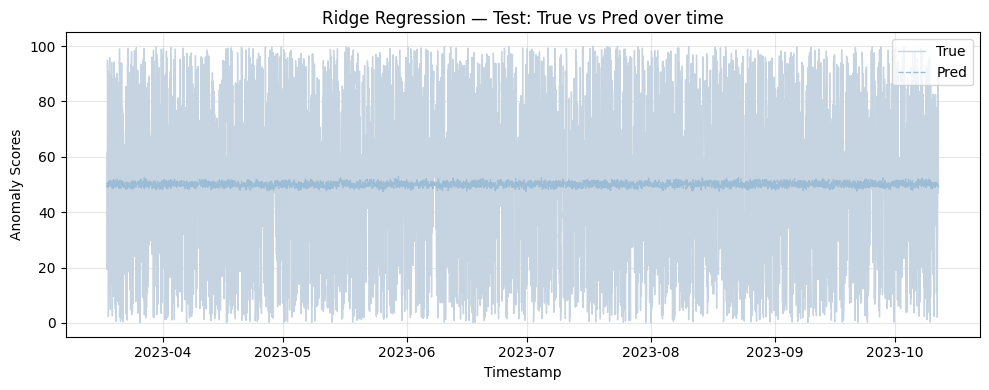


Anomaly regression experiment: Lasso Regression
== Val ==
MAE : 25.0273
RMSE: 28.9298
R2  : -0.0002
== Test ==
MAE : 25.0376
RMSE: 28.9134
R2  : -0.0005


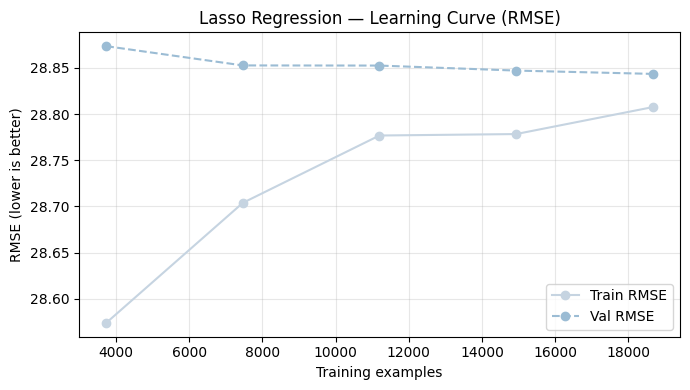

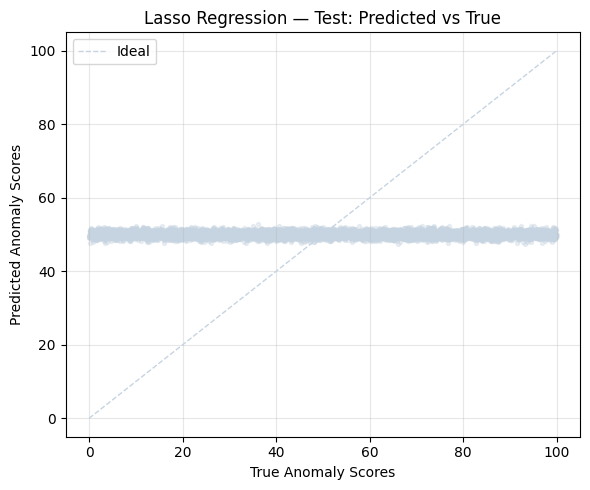

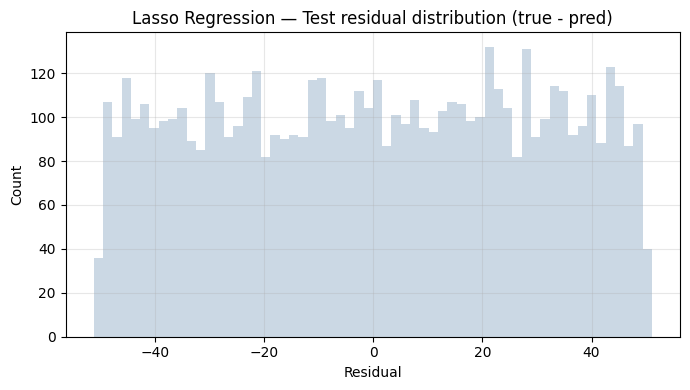

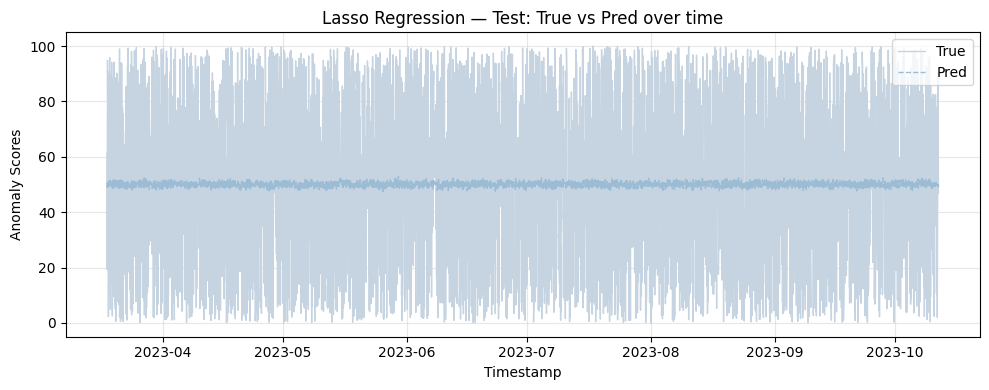


Anomaly regression experiment: ElasticNet Regression
== Val ==
MAE : 25.0273
RMSE: 28.9298
R2  : -0.0002
== Test ==
MAE : 25.0375
RMSE: 28.9134
R2  : -0.0005


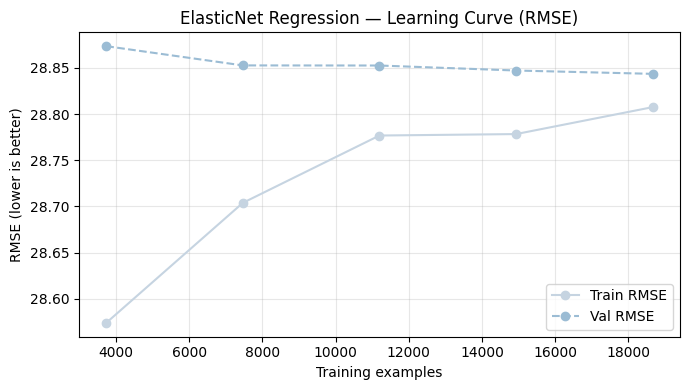

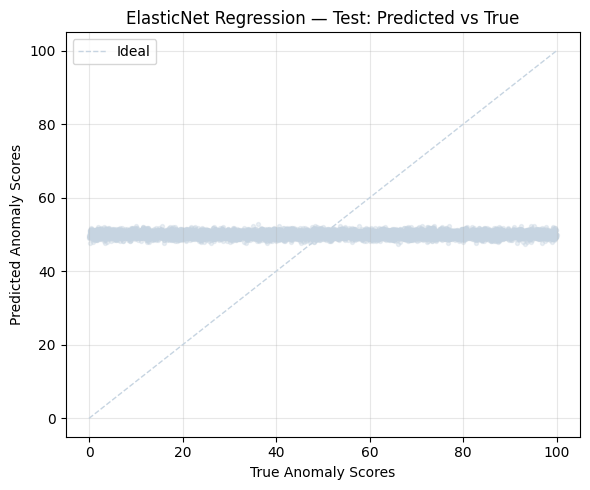

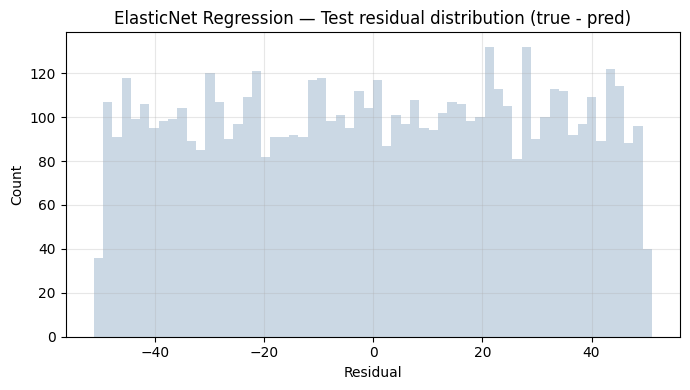

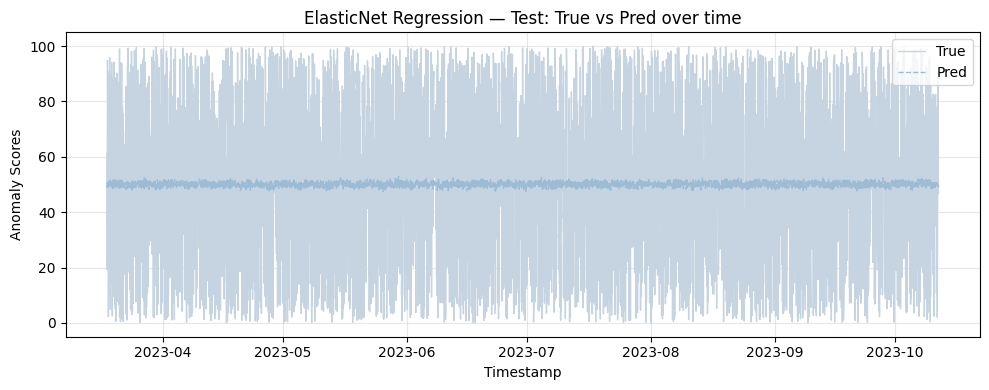


Anomaly regression experiment: KNN Regression
== Val ==
MAE : 25.3006
RMSE: 29.3806
R2  : -0.0316
== Test ==
MAE : 25.3783
RMSE: 29.5007
R2  : -0.0415


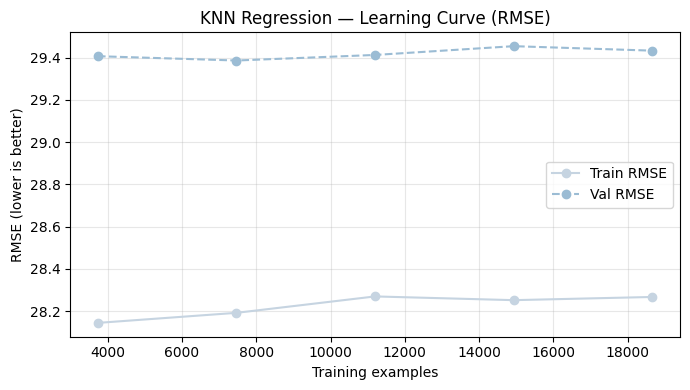

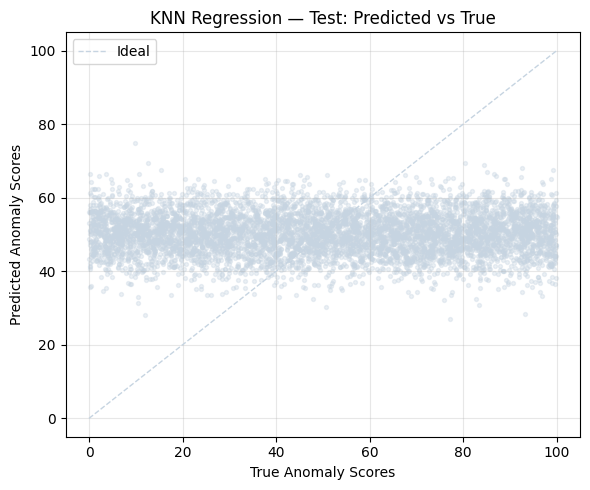

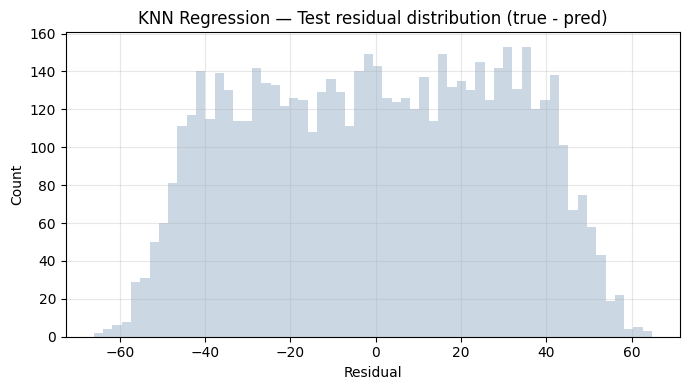

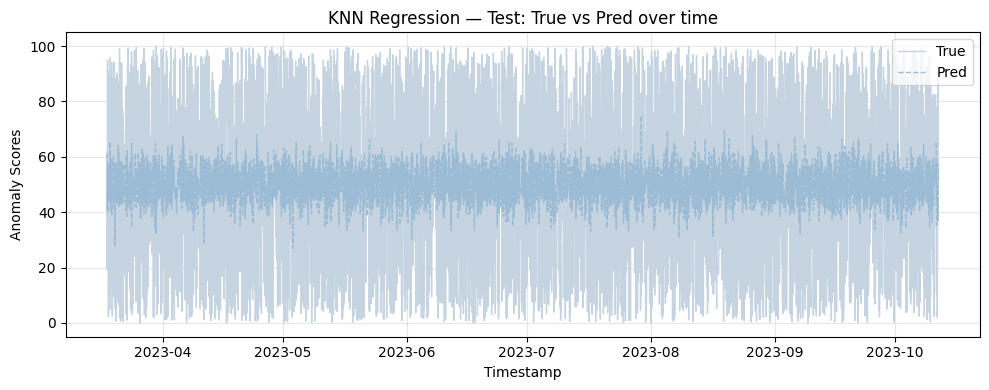


Anomaly regression experiment: SVR
== Val ==
MAE : 25.2315
RMSE: 29.2986
R2  : -0.0259
== Test ==
MAE : 25.3452
RMSE: 29.4257
R2  : -0.0362


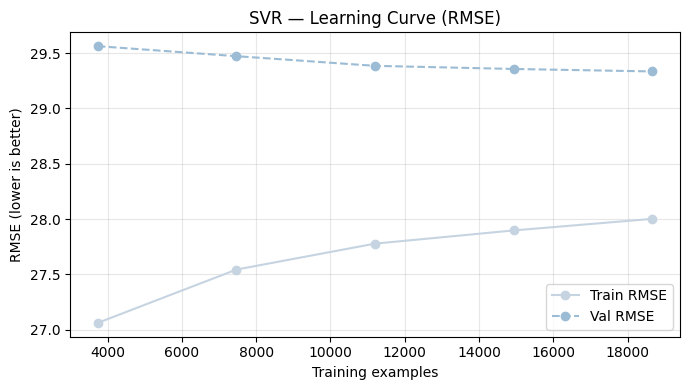

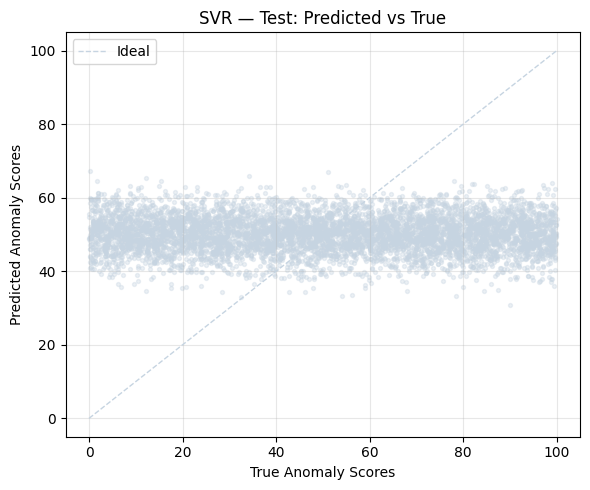

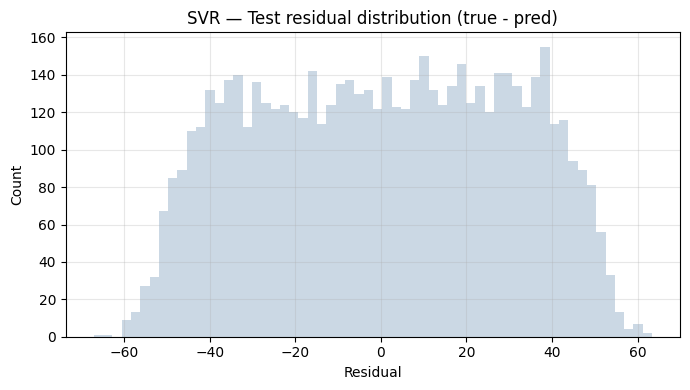

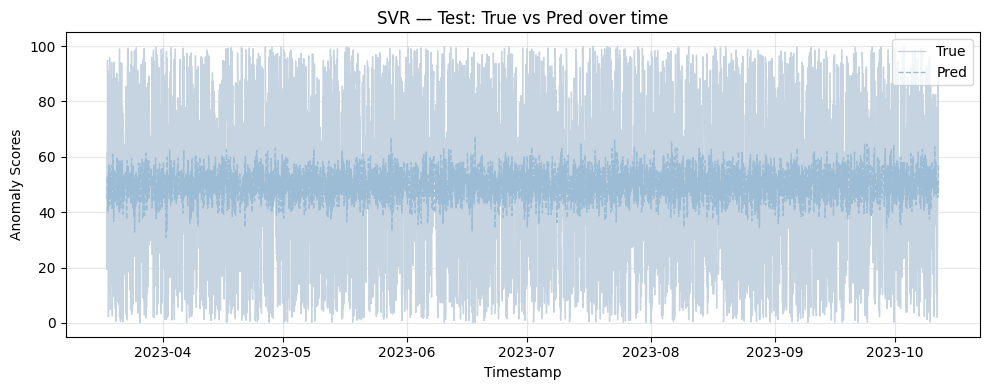


Anomaly regression experiment: Gradient Boosting Regression
== Val ==
MAE : 25.0487
RMSE: 28.9652
R2  : -0.0026
== Test ==
MAE : 25.0418
RMSE: 28.9154
R2  : -0.0006


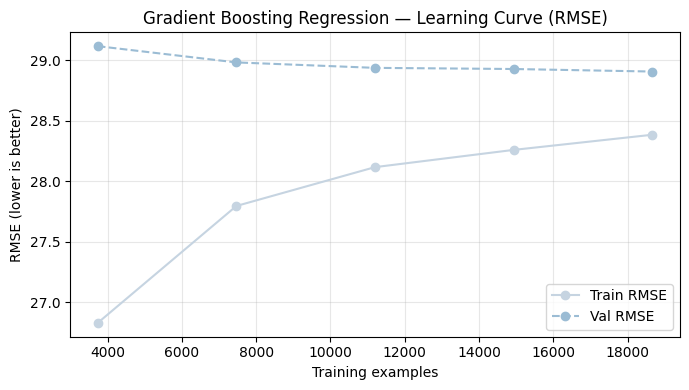

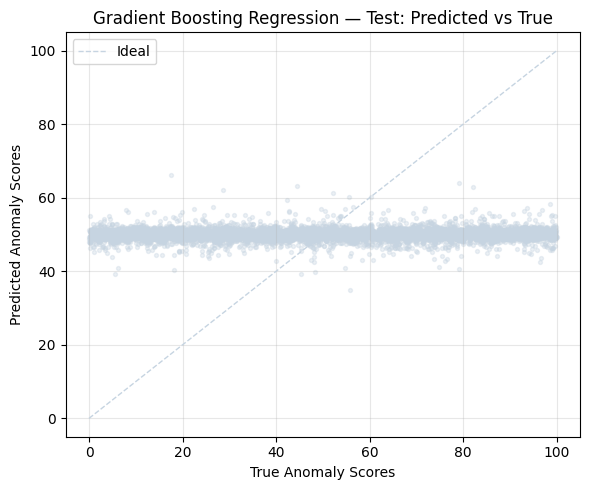

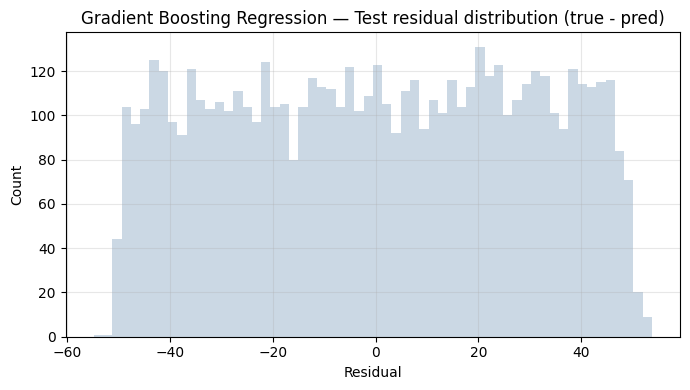

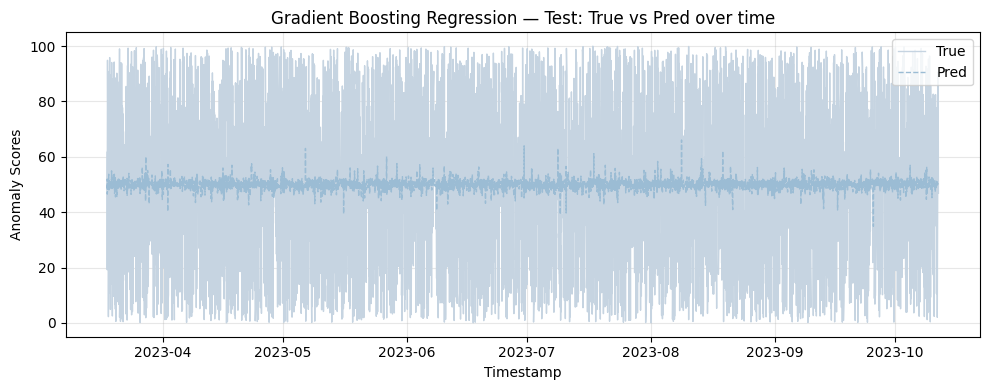


Anomaly regression experiment: Random Forest Regression
== Val ==
MAE : 25.1415
RMSE: 29.1264
R2  : -0.0138
== Test ==
MAE : 25.2201
RMSE: 29.2293
R2  : -0.0224


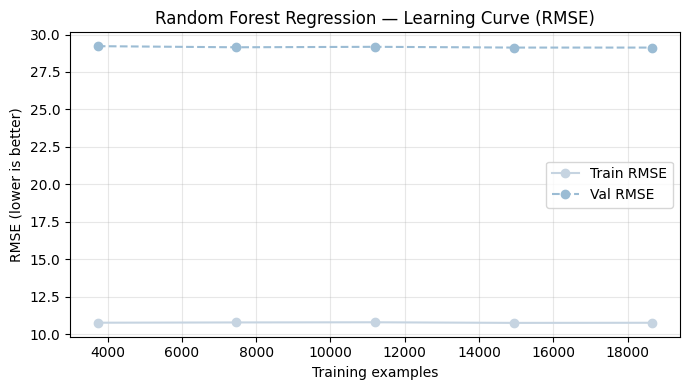

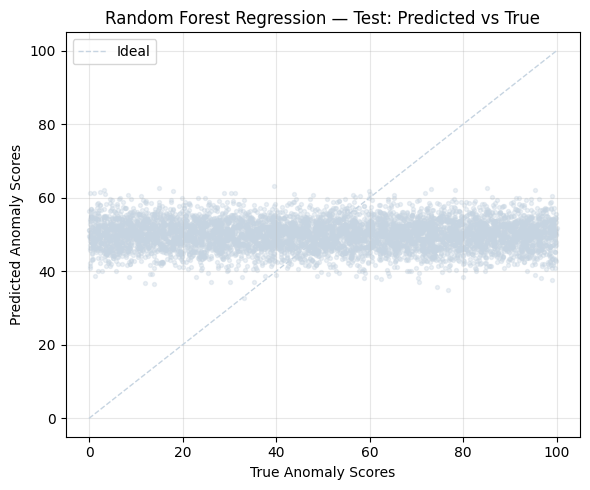

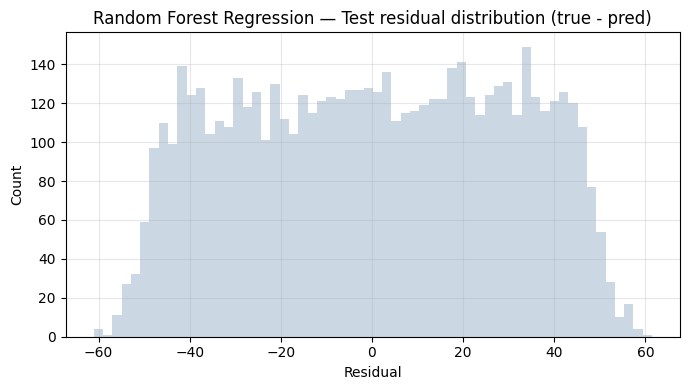

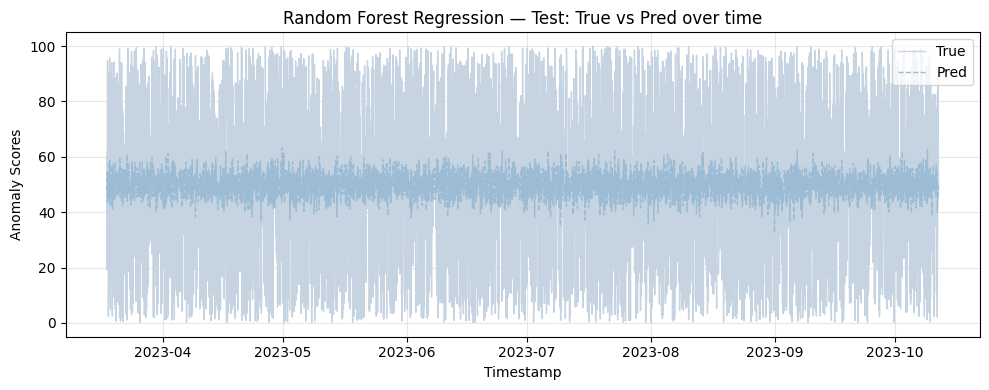


Anomaly regression experiment: XGBoost Regression
== Val ==
MAE : 25.3065
RMSE: 29.5216
R2  : -0.0415
== Test ==
MAE : 25.3721
RMSE: 29.4950
R2  : -0.0411


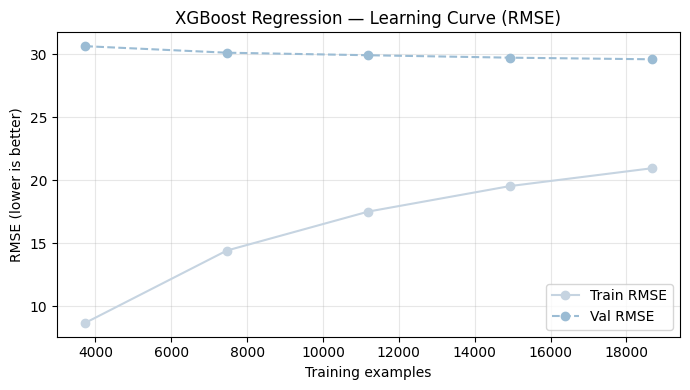

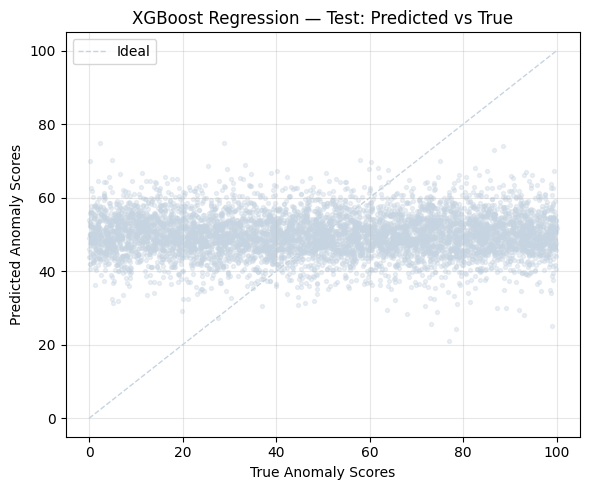

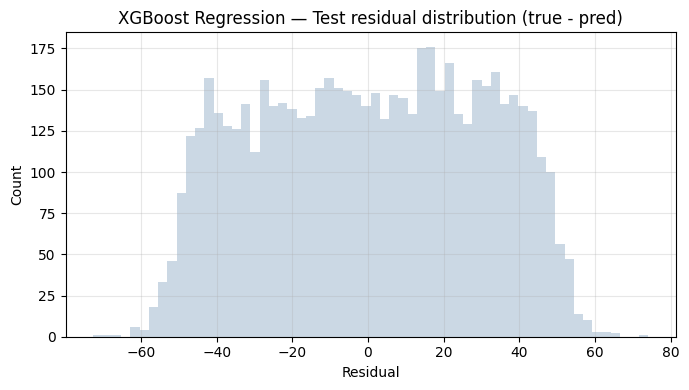

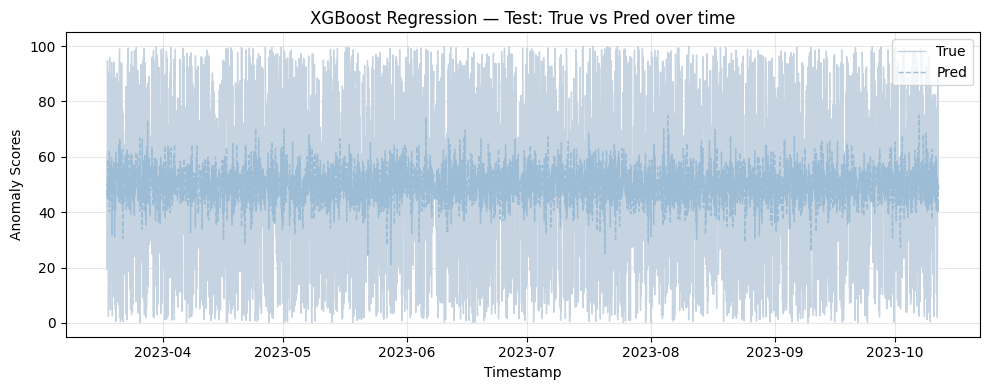

,model,val_mae,val_rmse,val_r2,test_mae,test_rmse,test_r2
0,Lasso Regression,25.027341,28.929819,-0.000197,25.037569,28.913439,-0.000468
1,ElasticNet Regression,25.027335,28.929848,-0.000199,25.037540,28.913441,-0.000468
2,Ridge Regression,25.027344,28.929905,-0.000203,25.037533,28.913477,-0.000470
3,Linear Regression,25.027345,28.929907,-0.000203,25.037534,28.913478,-0.000470
4,Gradient Boosting Regression,25.048661,28.965209,-0.002646,25.041827,28.915434,-0.000606
5,Random Forest Regression,25.141460,29.126353,-0.013833,25.220146,29.229290,-0.022445
6,SVR,25.231548,29.298622,-0.025861,25.345176,29.425678,-0.036231
7,XGBoost Regression,25.306508,29.521582,-0.041534,25.372067,29.495001,-0.041119
8,KNN Regression,25.300573,29.380572,-0.031608,25.378276,29.500708,-0.041522


In [9]:
# Build anomaly regression dataset (override baseline target to Anomaly Scores and drop Attack Type)
cfg0 = load_baseline_feature_config(BASELINE_CONFIG_JSON)
cfg_anom = BaselineFeatureConfig(
    target_col='Anomaly Scores',
    row_id_col=cfg0.row_id_col,
    drop_cols=sorted(set(cfg0.drop_cols + ['Attack Type'])),
    timestamp_cols=cfg0.timestamp_cols,
    port_cols=cfg0.port_cols,
)

X_full = apply_baseline_feature_config(df, cfg_anom)
y_full = pd.to_numeric(df[cfg_anom.target_col], errors='coerce')

X_train = X_full.loc[mask_train].reset_index(drop=True)
y_train = y_full.loc[mask_train].reset_index(drop=True)
X_val = X_full.loc[mask_val].reset_index(drop=True)
y_val = y_full.loc[mask_val].reset_index(drop=True)
X_test = X_full.loc[mask_test].reset_index(drop=True)
y_test = y_full.loc[mask_test].reset_index(drop=True)
ts_test = ts.loc[mask_test].reset_index(drop=True)

# Drop rows with missing regression target
train_ok = y_train.notna()
val_ok = y_val.notna()
test_ok = y_test.notna()

X_train, y_train = X_train.loc[train_ok].reset_index(drop=True), y_train.loc[train_ok].reset_index(drop=True)
X_val, y_val = X_val.loc[val_ok].reset_index(drop=True), y_val.loc[val_ok].reset_index(drop=True)
X_test, y_test = X_test.loc[test_ok].reset_index(drop=True), y_test.loc[test_ok].reset_index(drop=True)
ts_test = ts_test.loc[test_ok].reset_index(drop=True)

print('Anomaly regression split sizes:', X_train.shape, X_val.shape, X_test.shape)

@dataclass(frozen=True)
class RegressionExperiment:
    name: str
    estimator: object
    needs_scaling: bool

REG_EXPERIMENTS = [
    RegressionExperiment('Linear Regression', LinearRegression(), needs_scaling=False),
    RegressionExperiment('Ridge Regression', Ridge(alpha=1.0, random_state=SEED), needs_scaling=True),
    RegressionExperiment('Lasso Regression', Lasso(alpha=0.001, random_state=SEED, max_iter=20000), needs_scaling=True),
    RegressionExperiment('ElasticNet Regression', ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=SEED, max_iter=20000), needs_scaling=True),
    RegressionExperiment('KNN Regression', KNeighborsRegressor(n_neighbors=25), needs_scaling=True),
    RegressionExperiment('SVR', SVR(C=10.0, epsilon=0.1), needs_scaling=True),
    RegressionExperiment('Gradient Boosting Regression', GradientBoostingRegressor(random_state=SEED), needs_scaling=False),
    RegressionExperiment('Random Forest Regression', RandomForestRegressor(n_estimators=300, random_state=SEED, n_jobs=-1), needs_scaling=False),
    RegressionExperiment('XGBoost Regression', XGBRegressor(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='reg:squarederror',
        random_state=SEED,
        n_jobs=-1,
    ), needs_scaling=False),
]

anom_rows = []

for exp in REG_EXPERIMENTS:
    print('\n' + '=' * 80)
    print('Anomaly regression experiment:', exp.name)

    preprocess = make_preprocess(X_train, needs_scaling=exp.needs_scaling)
    model = Pipeline(steps=[('preprocess', preprocess), ('model', exp.estimator)])

    model.fit(X_train, y_train)

    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    val_m = regression_metrics(y_val, val_pred)
    test_m = regression_metrics(y_test, test_pred)

    pretty_print_regression('Val', val_m)
    pretty_print_regression('Test', test_m)

    slug = exp.name.lower().replace(' ', '_').replace('-', '_')
    plot_learning_curve_rmse(model, exp.name + ' — Learning Curve (RMSE)', 'anomaly_' + slug + '_learning_curve.png')
    plot_regression_diagnostics(exp.name, y_test, test_pred, ts_test, prefix='anomaly_' + slug)

    anom_rows.append({
        'model': exp.name,
        'val_mae': val_m['mae'],
        'val_rmse': val_m['rmse'],
        'val_r2': val_m['r2'],
        'test_mae': test_m['mae'],
        'test_rmse': test_m['rmse'],
        'test_r2': test_m['r2'],
    })

anom_summary = pd.DataFrame(anom_rows).sort_values('test_rmse', ascending=True).reset_index(drop=True)
anom_summary

## A.3 — Test Set Evaluation (Attack Type)

For **Attack Type**, the latest experiment artifacts are persisted under `data/04-predictions/attack_type/training/`.

For each model we:
- Load the latest `*_metrics.json` and `*_test_predictions.csv`
- Compute a normalized confusion matrix on the test set
- Render per-class precision/recall/F1 and overall accuracy + macro/weighted F1

Latest attack_type runs found:
- random_forest -> 20251229_182030
- xgboost -> 20251229_173211


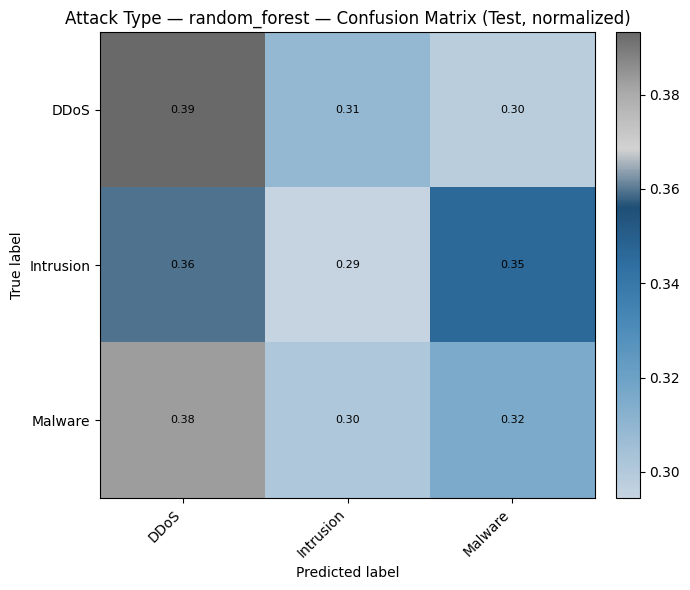

,precision,recall,f1-score,support
DDoS,0.3526,0.3932,0.3718,295.0000
Intrusion,0.3282,0.2945,0.3105,292.0000
Malware,0.3201,0.3156,0.3179,282.0000
accuracy,0.3349,0.3349,0.3349,0.3349
macro avg,0.3337,0.3344,0.3334,869.0000
weighted avg,0.3339,0.3349,0.3337,869.0000


=== Final Test Metrics ===
Model       : random_forest
Accuracy    : 0.3349
Macro F1    : 0.3334
Weighted F1 : 0.3337


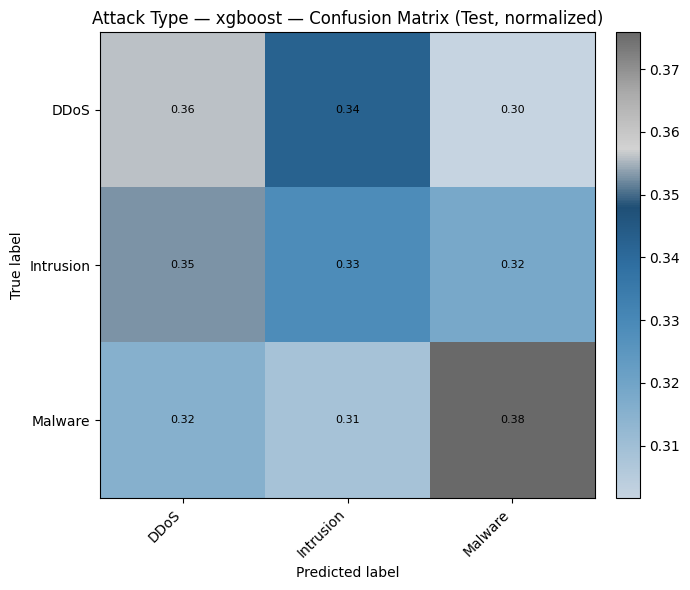

,precision,recall,f1-score,support
DDoS,0.3535,0.3559,0.3547,295.0000
Intrusion,0.3380,0.3288,0.3333,292.0000
Malware,0.3681,0.3759,0.3719,282.0000
accuracy,0.3533,0.3533,0.3533,0.3533
macro avg,0.3532,0.3535,0.3533,869.0000
weighted avg,0.3530,0.3533,0.3531,869.0000


=== Final Test Metrics ===
Model       : xgboost
Accuracy    : 0.3533
Macro F1    : 0.3533
Weighted F1 : 0.3531


,model,run_dir,val_accuracy,val_macro_f1,val_weighted_f1,test_accuracy,test_macro_f1,test_weighted_f1
0,xgboost,20251229_173211,0.336667,0.336652,0.336681,0.335000,0.334945,0.334949
1,random_forest,20251229_182030,0.333500,0.333495,0.333501,0.327333,0.327248,0.327259


In [10]:
def clean_predictions_csv(path: Path) -> pd.DataFrame:
    pred = pd.read_csv(path)
    # Drop blank rows (some files include lines without row_id/y_true)
    pred = pred.dropna(subset=['y_true', 'y_pred'])
    pred['y_true'] = pred['y_true'].astype(float).round().astype(int)
    pred['y_pred'] = pred['y_pred'].astype(float).round().astype(int)
    return pred

def plot_confusion(cm: np.ndarray, class_names: list, title: str, png_name: str) -> None:
    cm = cm.astype(float)
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    cmn = cm / row_sums

    plt.figure(figsize=(7, 6))
    im = plt.imshow(cmn, aspect='auto', cmap=CMAP)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.yticks(range(len(class_names)), class_names)

    for i in range(cmn.shape[0]):
        for j in range(cmn.shape[1]):
            plt.text(j, i, f'{cmn[i, j]:.2f}', ha='center', va='center', fontsize=8)

    plt.colorbar(im, fraction=0.046, pad=0.04)
    savefig(png_name)
    plt.show()

attack_train_root = PRED_ROOT / 'attack_type' / 'training'
run_dirs = [p for p in attack_train_root.iterdir() if p.is_dir()]
if not run_dirs:
    raise FileNotFoundError('No attack_type training runs found under data/04-predictions/attack_type/training/')

# Keep latest run per model (based on timestamped folder name)
by_model = {}
for rd in sorted(run_dirs, key=lambda p: p.name):
    for mf in rd.glob('attack_type_*_metrics.json'):
        model = mf.name.replace('attack_type_', '').replace('_metrics.json', '')
        pf = rd / ('attack_type_' + model + '_test_predictions.csv')
        if pf.exists():
            by_model[model] = {'run_dir': rd, 'metrics': mf, 'preds': pf}

print('Latest attack_type runs found:')
for model, info in sorted(by_model.items()):
    print('-', model, '->', info['run_dir'].name)

rows = []
for model, info in sorted(by_model.items()):
    metrics = json.loads(info['metrics'].read_text(encoding='utf-8'))
    pred_df = clean_predictions_csv(info['preds'])

    y_true = pred_df['y_true'].to_numpy()
    y_pred = pred_df['y_pred'].to_numpy()

    labels = list(range(len(ATTACK_CLASSES)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plot_confusion(cm, ATTACK_CLASSES, 'Attack Type — ' + model + ' — Confusion Matrix (Test, normalized)', 'attack_type_' + model + '_confusion_matrix.png')

    report = classification_report(y_true, y_pred, target_names=ATTACK_CLASSES, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).T
    display(report_df.style.format(precision=4))

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    print('=== Final Test Metrics ===')
    print('Model       :', model)
    print('Accuracy    :', f'{acc:.4f}')
    print('Macro F1    :', f'{macro_f1:.4f}')
    print('Weighted F1 :', f'{weighted_f1:.4f}')

    val = metrics.get('val', {})
    test = metrics.get('test', {})

    rows.append({
        'model': model,
        'run_dir': info['run_dir'].name,
        'val_accuracy': float(val.get('accuracy', np.nan)),
        'val_macro_f1': float(val.get('macro_f1', np.nan)),
        'val_weighted_f1': float(val.get('weighted_f1', np.nan)),
        'test_accuracy': float(test.get('accuracy', acc)),
        'test_macro_f1': float(test.get('macro_f1', macro_f1)),
        'test_weighted_f1': float(test.get('weighted_f1', weighted_f1)),
    })

attack_summary = pd.DataFrame(rows).sort_values('test_macro_f1', ascending=False).reset_index(drop=True)
attack_summary

## Overall conclusions

Primary model selection criteria (test split):
- **Anomaly Scores:** lowest test RMSE
- **Attack Type:** highest test macro-F1

In [11]:
best_anom = anom_summary.iloc[0]
best_attack = attack_summary.iloc[0]

print('=== Best Anomaly Score Model (by test RMSE) ===')
print('Model    :', best_anom['model'])
print('Test RMSE:', f"{best_anom['test_rmse']:.4f}")
print('Test MAE :', f"{best_anom['test_mae']:.4f}")
print('Test R2  :', f"{best_anom['test_r2']:.4f}")

print('\n=== Best Attack Type Model (by test macro-F1) ===')
print('Model        :', best_attack['model'])
print('Run dir      :', best_attack['run_dir'])
print('Test macro-F1:', f"{best_attack['test_macro_f1']:.4f}")
print('Test accuracy:', f"{best_attack['test_accuracy']:.4f}")

display(anom_summary)
display(attack_summary)

=== Best Anomaly Score Model (by test RMSE) ===
Model    : Lasso Regression
Test RMSE: 28.9134
Test MAE : 25.0376
Test R2  : -0.0005

=== Best Attack Type Model (by test macro-F1) ===
Model        : xgboost
Run dir      : 20251229_173211
Test macro-F1: 0.3349
Test accuracy: 0.3350


,model,val_mae,val_rmse,val_r2,test_mae,test_rmse,test_r2
0,Lasso Regression,25.027341,28.929819,-0.000197,25.037569,28.913439,-0.000468
1,ElasticNet Regression,25.027335,28.929848,-0.000199,25.037540,28.913441,-0.000468
2,Ridge Regression,25.027344,28.929905,-0.000203,25.037533,28.913477,-0.000470
3,Linear Regression,25.027345,28.929907,-0.000203,25.037534,28.913478,-0.000470
4,Gradient Boosting Regression,25.048661,28.965209,-0.002646,25.041827,28.915434,-0.000606
5,Random Forest Regression,25.141460,29.126353,-0.013833,25.220146,29.229290,-0.022445
6,SVR,25.231548,29.298622,-0.025861,25.345176,29.425678,-0.036231
7,XGBoost Regression,25.306508,29.521582,-0.041534,25.372067,29.495001,-0.041119
8,KNN Regression,25.300573,29.380572,-0.031608,25.378276,29.500708,-0.041522


,model,run_dir,val_accuracy,val_macro_f1,val_weighted_f1,test_accuracy,test_macro_f1,test_weighted_f1
0,xgboost,20251229_173211,0.336667,0.336652,0.336681,0.335000,0.334945,0.334949
1,random_forest,20251229_182030,0.333500,0.333495,0.333501,0.327333,0.327248,0.327259
